### Ethena USDe reserve fund drawdown simulations
Evaluating different stress scenarios which could cause reserve fund drawdowns

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
def get_daily_drawdown(total_exposure, funding_rate):
    """
    Calculate the daily drawdown given an annualized funding rate and total exposure to perpetual positions.
    """
    daily_rate = funding_rate / 365
    return total_exposure * daily_rate

In [3]:
def get_daily_lst_gain(total_exposure, lst_proportion, lst_rate):
    """
    Calculate the daily yield of LST collateral given an LST APY.
    """
    daily_rate = lst_rate / 365
    return total_exposure * lst_proportion * daily_rate

In [4]:
def run_simulation(total_exposure, initial_reserve_fund, annualized_funding_rates, lst_rate=0, lst_proportion=0):
    """
    Run the simulation until the reserve fund is depleted. Can optionally add LST rate.
    """
    results = {}
    for rate in annualized_funding_rates:
        daily_drawdown = get_daily_drawdown(total_exposure, rate)
        daily_lst_gain = get_daily_lst_gain(total_exposure, lst_proportion, lst_rate)
        reserve_fund = initial_reserve_fund / 1e6  # Convert to millions
        fund_values = [reserve_fund]
        while reserve_fund > 0:
            reserve_fund += daily_drawdown / 1e6  # Convert to millions
            reserve_fund += daily_lst_gain / 1e6  # Convert to millions
            fund_values.append(reserve_fund)

        results[rate] = fund_values
    return results

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, past_results=None, tick_size=3):
    """
    Plot the results for different funding rates.
    Optionally compare with past results using dashed lines.
    
    Parameters:
    - results: dict, current results to be plotted
    - past_results: dict, past results to be compared
    """
    plt.figure(figsize=(12, 8))

    # Define a color cycle
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    color_dict = {rate: color for rate, color in zip(results.keys(), colors)}

    # Plot current results
    for rate, values in results.items():
        plt.plot(values, label=f'Funding Rate: {int(rate*100)}%', linestyle='solid', color=color_dict[rate])

    # Plot past results if provided
    if past_results:
        for rate, values in past_results.items():
            plt.plot(values, label=f'Funding Rate (base case): {int(rate*100)}%', linestyle='dashed', color=color_dict[rate])

    max_days = max(len(values) for values in results.values())
    if past_results:
        max_new = max(len(values) for values in past_results.values())
        max_days = max(max_days, max_new)
    plt.xticks(range(0, max_days, tick_size))

    # Set x-axis and y-axis limits
    plt.xlim(left=0)
    plt.ylim(bottom=0)

    # Set y-axis ticks and gridlines
    y_max = plt.gca().get_ylim()[1]
    major_ticks = np.arange(0, y_max + 5, 5)  # Major ticks every 5 million
    plt.yticks(major_ticks)

    plt.title('Reserve Fund Drawdown Over Time', fontname='Arial', fontweight='bold', fontsize=16)
    plt.xlabel('Days', fontname='Arial', fontsize=14)
    plt.ylabel('Reserve Fund Value (Million USD)', fontname='Arial', fontsize=14)
    
    plt.legend(prop={'family': 'Arial', 'size': 14})
    
    # Change font for tick labels and format y-axis labels
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Set grid
    plt.grid(True, axis='both', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

**Scenario 1:** Negative funding rates, market reaction is neutral and reserve fund asset liquidity is not impacted

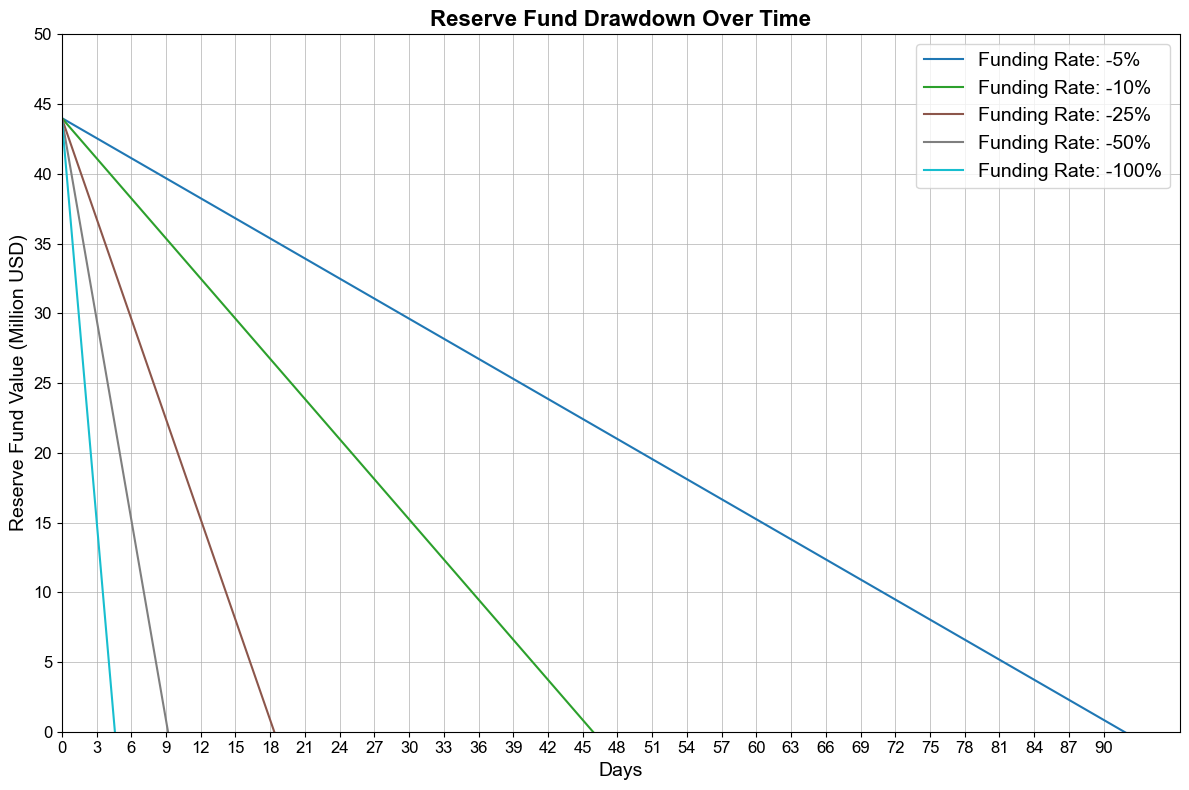

In [6]:
# Parameters
total_exposure = 3500000000 # $3.5B
reserve_fund = 44000000 # $44M
annualized_funding_rates = [-0.05, -0.10, -0.25, -0.50, -1]

# Simulation
results = run_simulation(total_exposure, reserve_fund, annualized_funding_rates)
plot_results(results)

In [7]:
for rate, values in results.items():
    print(rate, ": ", len(values))

-0.05 :  93
-0.1 :  47
-0.25 :  20
-0.5 :  11
-1 :  6


**Evaluating the likelihood of such situations based on historical data**

Based on historical funding rate data analysis which covers data from all 4 CEX that Ethena uses, we have performed reserve fund drawdown analysis and observed that from 2019-09 to 2024-05 there has been an isolated instance where negative funding rates would have drained the reserve fund:

Negative average annualized funding rates of -27% were persistent for 24 days from the 23rd of August, 2022 to 16th of September, 2022.

However, there are two assumptions made in this simulation:
1) All of the positions are held in ETH perps
2) The negative periods end as soon as there is a single day with positive funding rates. In reality, there could be two non-overlapping negative periods one after another.

| threshold_group | count | likelihood | mean\_length\_hours | probability  |
|:----------------|:------|:-----------|:--------------------|:-------------|
| &lt;= -50%      | 10    | 0.024752   | 177.600000          | 3.392286e-01 |
| &lt;= -25%      | 20    | 0.049505   | 156.000000          | 6.271022e-02 |
| &lt;= -10%      | 47    | 0.116337   | 95.489362           | 7.408858e-06 |
| &lt;= -5%       | 173   | 0.428218   | 62.705202           | 1.109738e-17 |


**Scenario 2:** Negative funding rates, market reaction is negative and therefore liquidity of the reserve fund gets affected. Uniswap V3 Pool positions and sDAI get discounted by [5%, 10%, 20%] while USDT keeps the peg and is not affected.

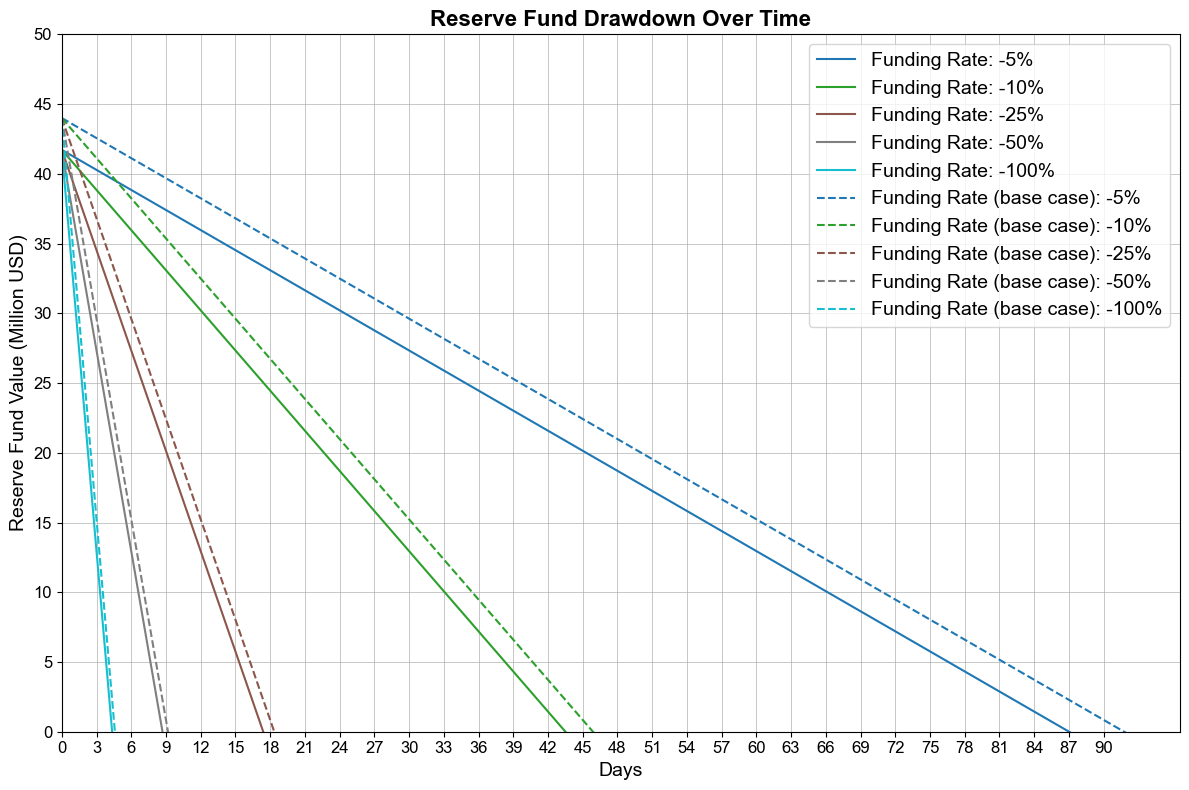

-0.05 :  89
-0.1 :  45
-0.25 :  19
-0.5 :  10
-1 :  6
41720000.0


In [8]:
# Parameters
total_exposure = 3500000000 # $3.5B
reserve_fund = 44000000 # $44M
sdai_position = 15500000 # $15.5M
uniswap_position = 11400000 # $11.4M
discount_factors = [0.2]
annualized_funding_rates = [-0.05, -0.10, -0.25, -0.50, -1]

# Simulations
for discount in discount_factors:
    reserve_fund_discounted = reserve_fund - (uniswap_position * discount)
    results = run_simulation(total_exposure, reserve_fund_discounted, annualized_funding_rates)
    past_results = run_simulation(total_exposure, reserve_fund, annualized_funding_rates)
    plot_results(results, past_results)
    for rate, values in results.items():
        print(rate, ": ", len(values))
    print(reserve_fund_discounted)

**Evaluating likelihood of such situations based on historical data**
In this scenario when a 20% discount is applied, one additional instance of reserve fund depletion is observed during a 21-day period in July, 2021. Moreover, due to a lower liquid value of the reserve fund, the likelihood of the depletion increases.

| threshold\_group | count<br/> | likelihood<br/> | mean\_length\_hours<br/> | probability<br/> |
|:-----------------| :--- | :--- | :--- | :--- |
| &lt;= -50%       | 10 | 0.024752 | 177.600000 | 3.883121e-01 |
| &lt;= -25%       | 20 | 0.049505 | 156.000000 | 9.949058e-02 |
| &lt;= -10%       | 47 | 0.116337 | 95.489362 | 5.533311e-05 |
| &lt;= -5%        | 173 | 0.428218 | 62.705202 | 1.597584e-14 |



**Scenario 3:** Funding rates are negative, market volatility is persisent and users start to redeem USDe for collateral forcing Ethena to close perpetual positions incurring slippage. Let's assume that users will only start to redeem USDe 5 days after the first drawdown of reserve fund.

USDe redeems are limited at 2M per block. They are also limited by the amount of collateral that a contract possesses. If the MintBurn contract does not possess enough collateral, redeeming will not be possible. Collateral can only be supplied manually by custodians. Therefore, Ethena only holds a small portion of collateral in the contract, and we can safely assume that they will try to mitigate the slippage impact by slowing down the collateral swaps by the custodians. However, Ethena can also completely pause redeeming on the contract level. We suppose that it would cause instant market panic and de-peg of USDe on secondary markets.

As historical slippage reference, ChaosLabs results were re-used for the purpose of this scenario. ChaosLabs estimated the upper bound on the slippage (in bps) incurred when executing the trades:

| Trade      | Median         | 95%       | 99%  |
|:-----------|:---------------|:----------|:-----|
| 500 ETH    | 1.8            | 3.5       | 4.4  |
| 1,000 ETH  | 2.8            | 5.1       | 7.0  |
| 5,000 ETH  | 10.6 | 17.4      | 23.1 |
| 10,000 ETH | 21.8 | 35.0 | 50.8 |

In [9]:
def calculate_slippage(percentages, total_position_usd, slippage_bps):
    """
    Calculate the total slippage when given percentages of USDe is redeemed and sold for collateral.
    """
    slippage_rate = slippage_bps / 10000  # Convert basis points to decimal
    slippage_costs = []

    for percentage in percentages:
        amount_to_be_sold_usd = (percentage / 100) * total_position_usd
        total_slippage = amount_to_be_sold_usd * slippage_rate
        slippage_costs.append(total_slippage)

    return slippage_costs


[1777999.9999999998, 3555999.9999999995, 5333999.999999999, 7111999.999999999, 8889999.999999998]


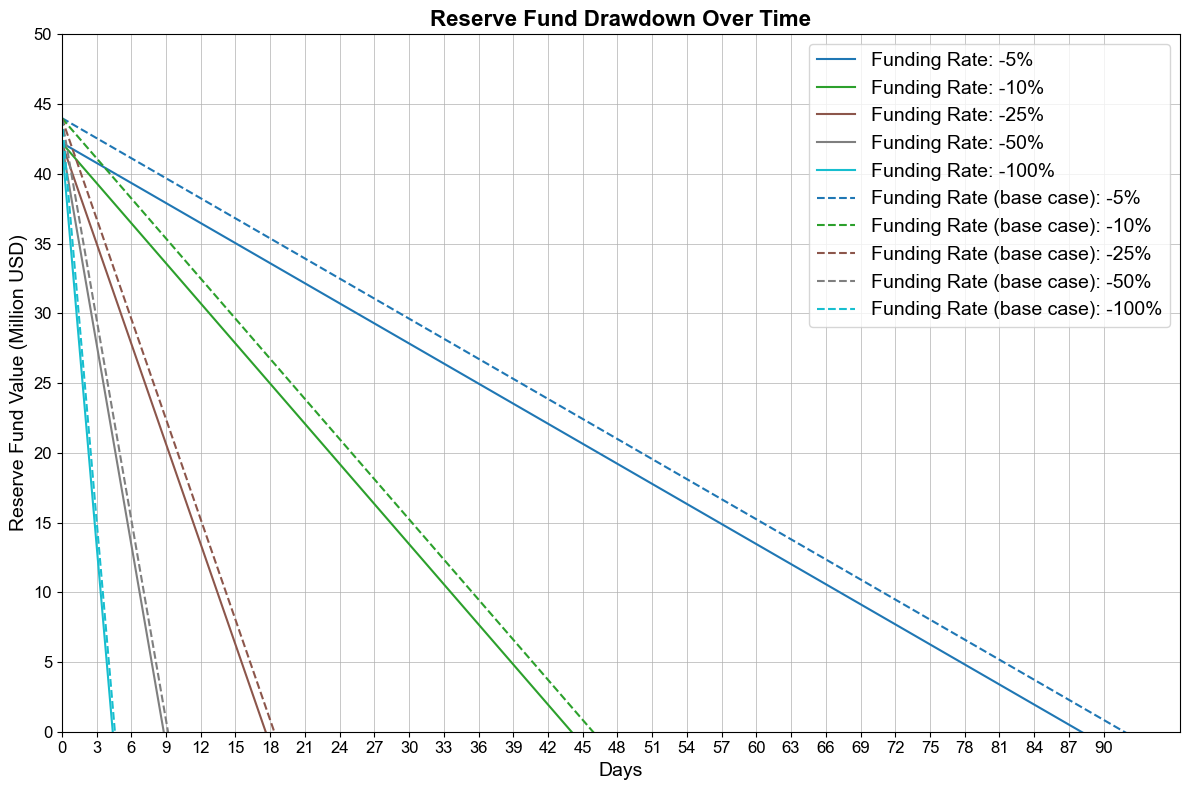

-0.05 :  90
-0.1 :  46
-0.25 :  19
-0.5 :  10
-1 :  6
42222000.0


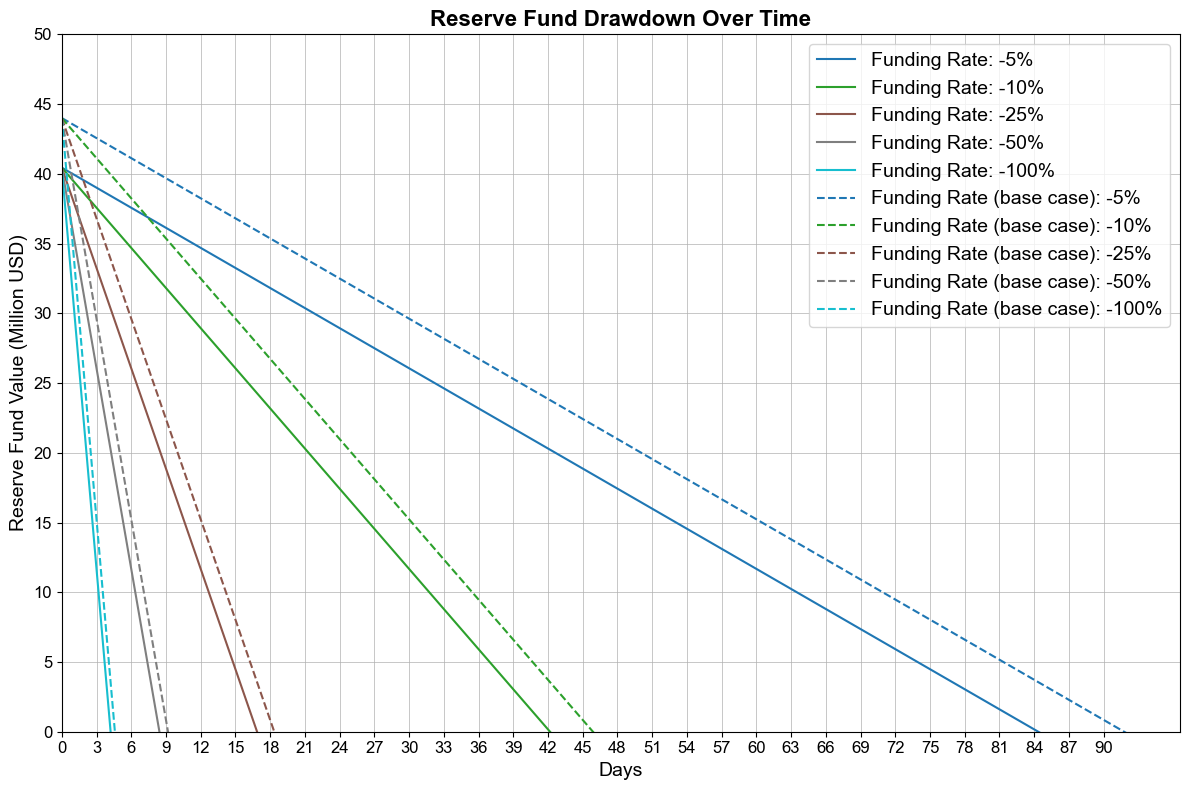

-0.05 :  86
-0.1 :  44
-0.25 :  18
-0.5 :  10
-1 :  6
40444000.0


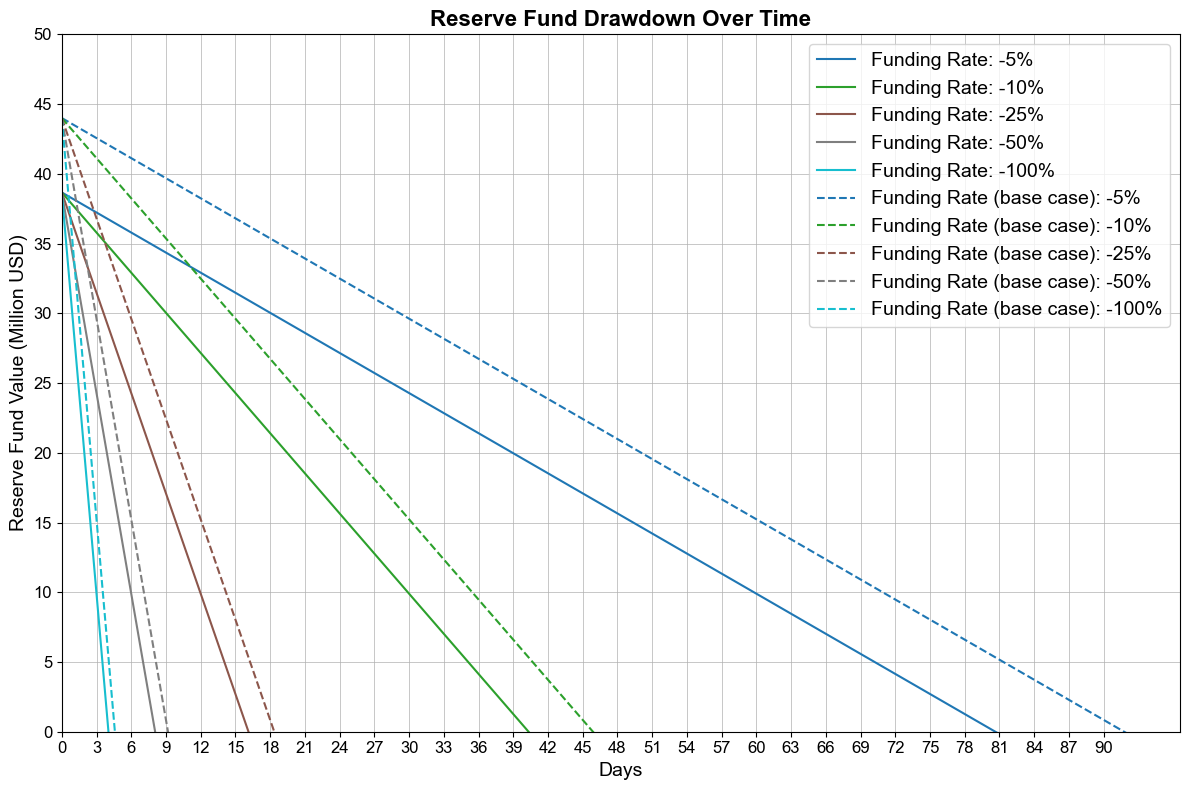

-0.05 :  82
-0.1 :  42
-0.25 :  18
-0.5 :  10
-1 :  6
38666000.0


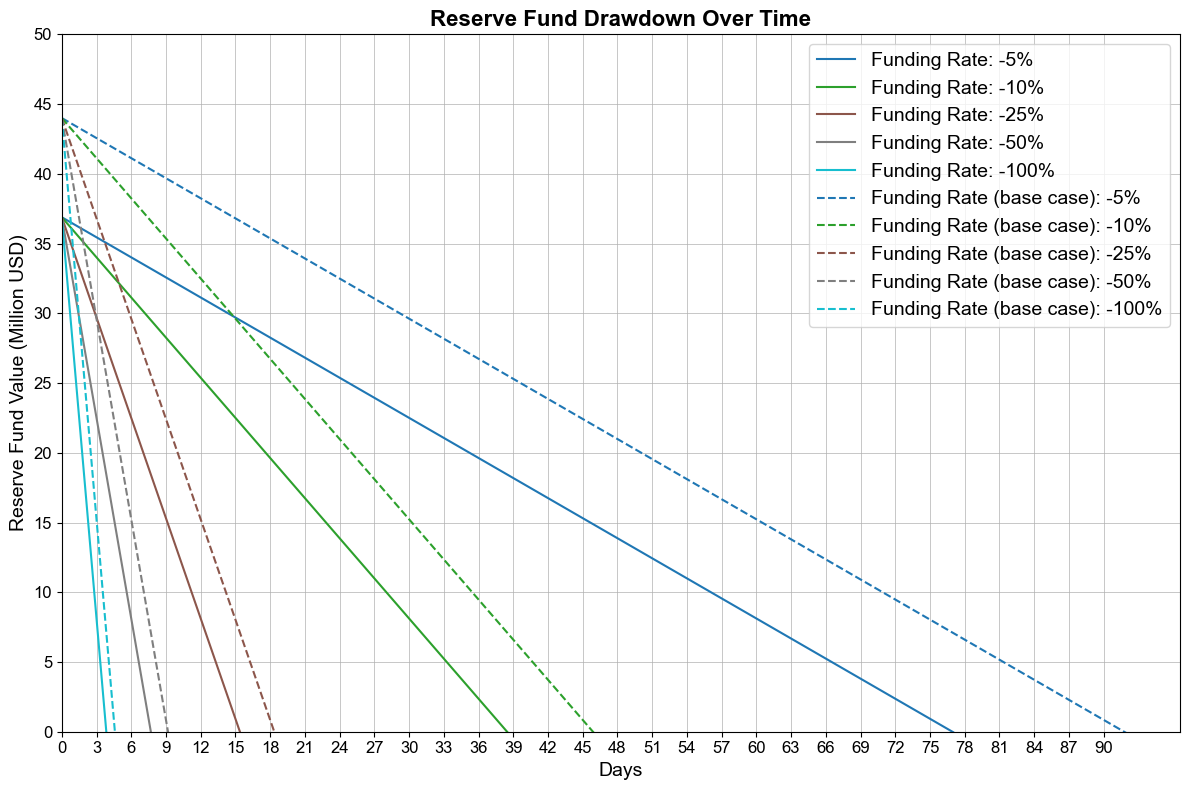

-0.05 :  78
-0.1 :  40
-0.25 :  17
-0.5 :  9
-1 :  5
36888000.0


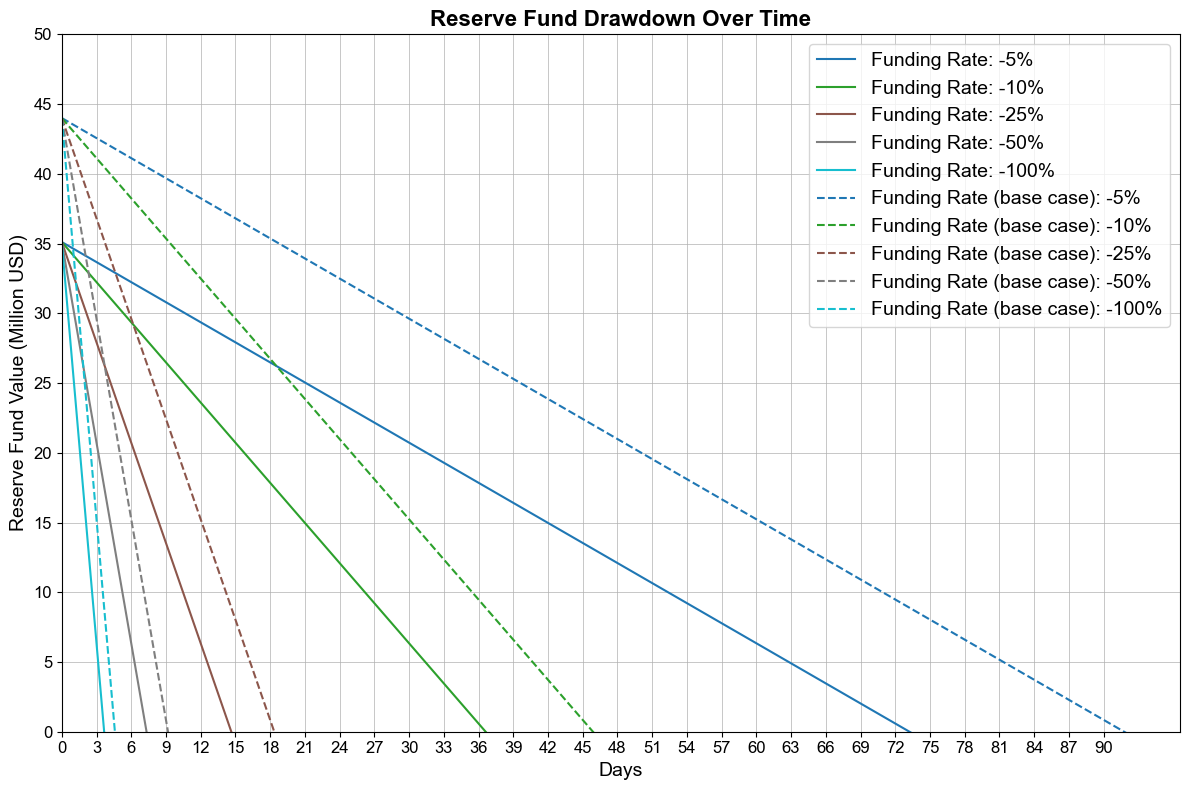

-0.05 :  75
-0.1 :  38
-0.25 :  16
-0.5 :  9
-1 :  5
35110000.0


In [10]:
percentages = [10, 20, 30, 40, 50]
total_position_usd = 3.5e9  # 3.5 billion USD
slippage_bps = 50.8  # 50.8 basis points

slippage_costs = calculate_slippage(percentages, total_position_usd, slippage_bps)
print(slippage_costs)

# Simulations
for i, slippage in enumerate(slippage_costs):
    reserve_fund_discounted = reserve_fund - slippage
    results = run_simulation(total_exposure, reserve_fund_discounted, annualized_funding_rates)
    past_results = run_simulation(total_exposure, reserve_fund, annualized_funding_rates)
    plot_results(results, past_results)
    for rate, values in results.items():
        print(rate, ": ", len(values))
    print(reserve_fund_discounted)

**Scenario 4:** Scenario 2 and 3 combined. This would mean that the assets get discounted and USDe gets redeemed, amplifying the effects.

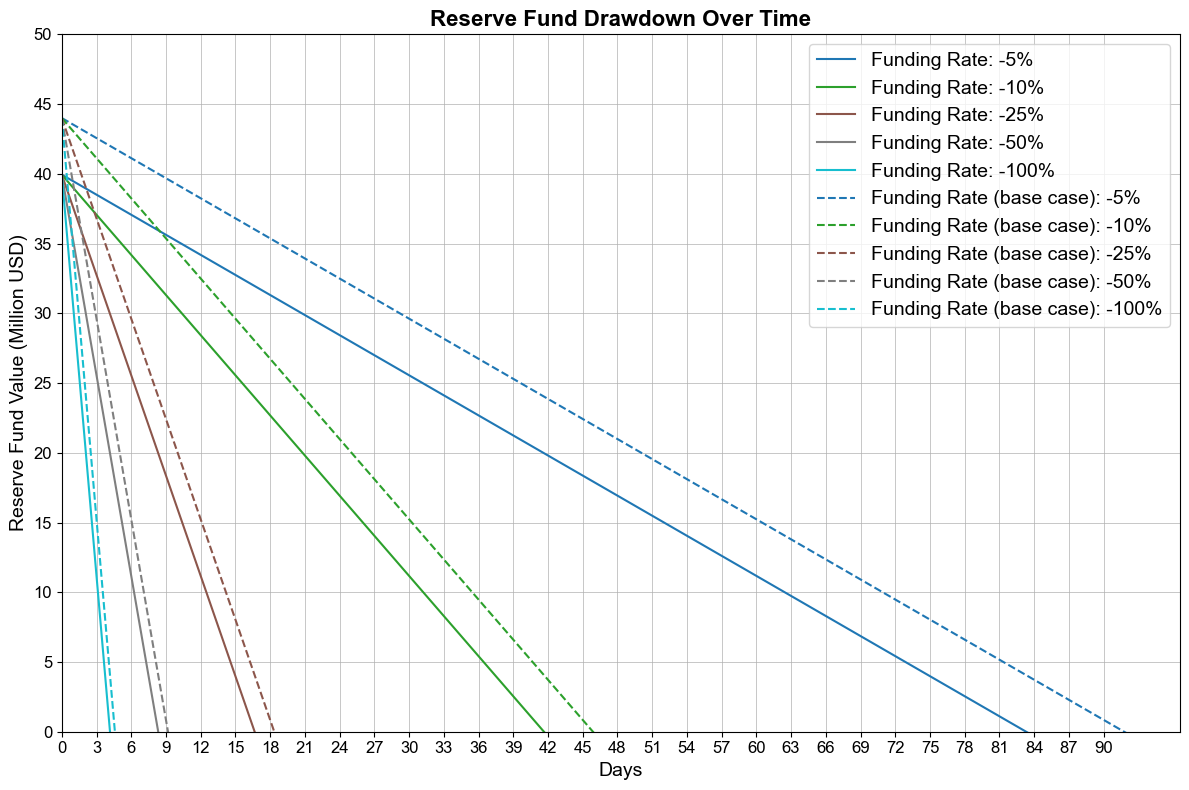

-0.05 :  85
-0.1 :  43
-0.25 :  18
-0.5 :  10
-1 :  6
39942000.0


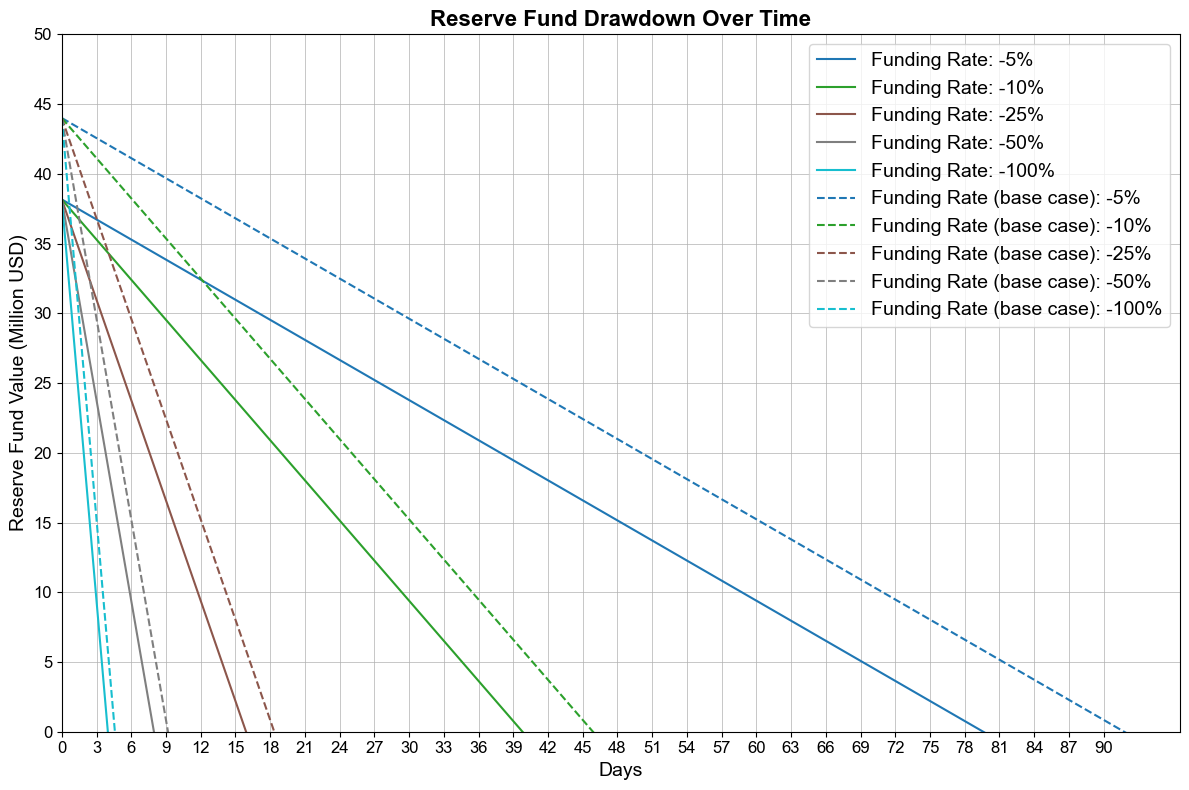

-0.05 :  81
-0.1 :  41
-0.25 :  17
-0.5 :  9
-1 :  5
38164000.0


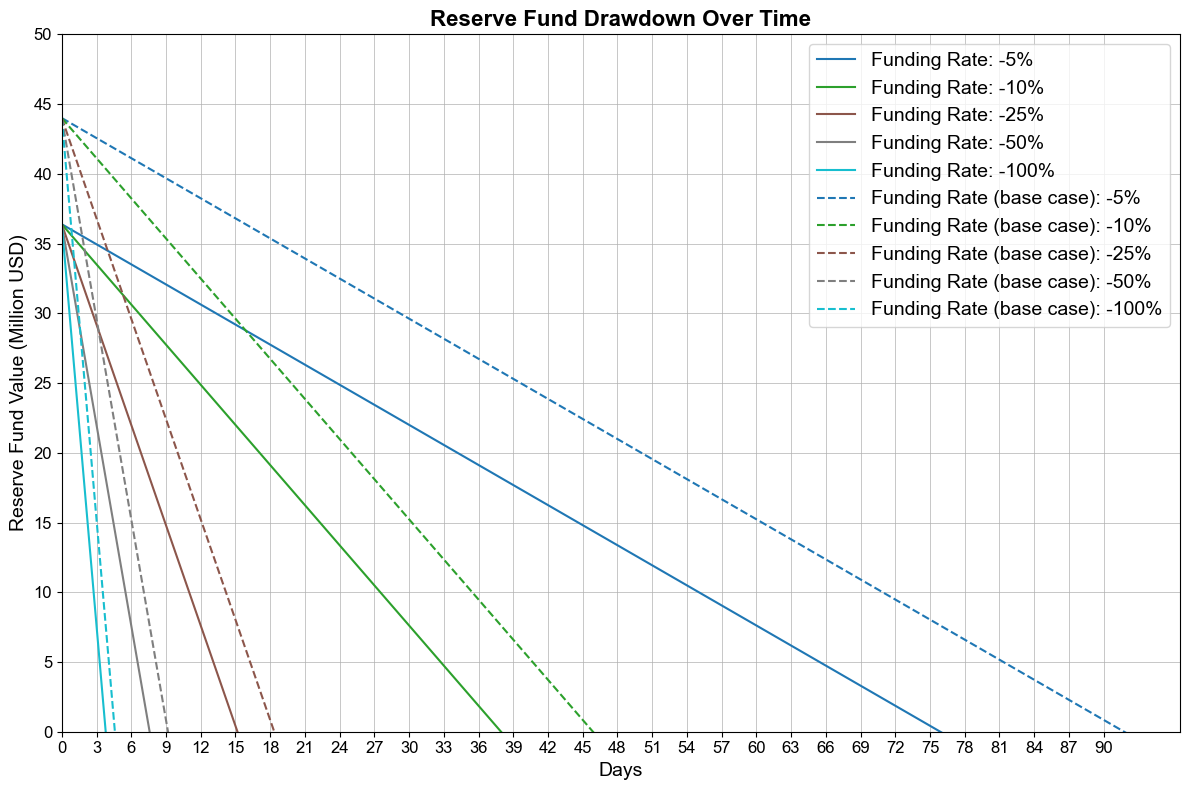

-0.05 :  77
-0.1 :  39
-0.25 :  17
-0.5 :  9
-1 :  5
36386000.0


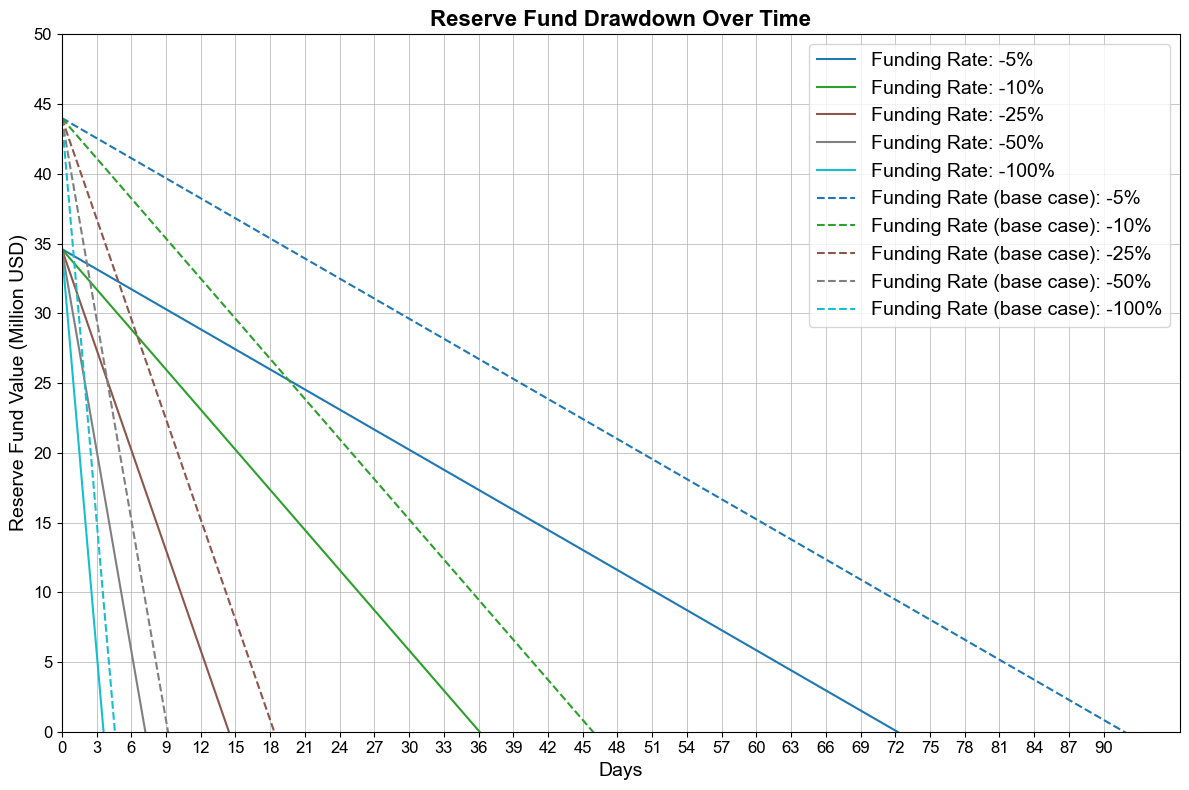

-0.05 :  74
-0.1 :  38
-0.25 :  16
-0.5 :  9
-1 :  5
34608000.0


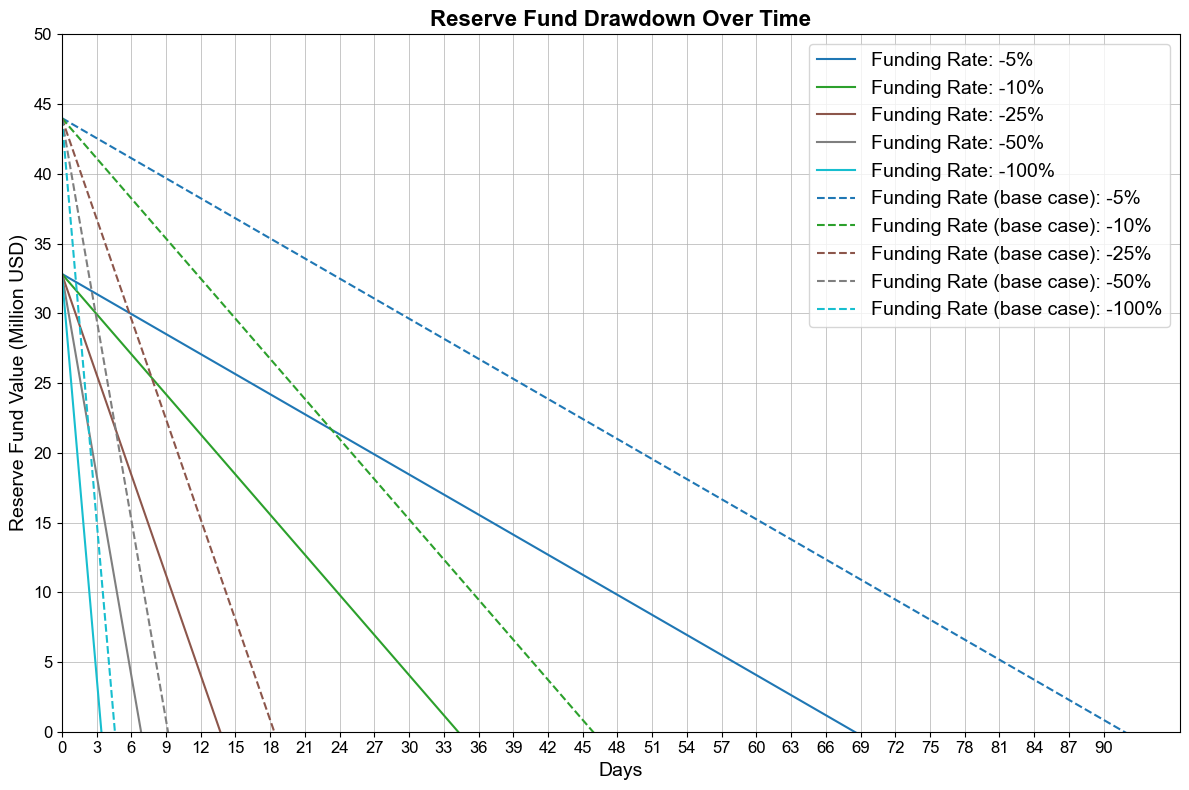

-0.05 :  70
-0.1 :  36
-0.25 :  15
-0.5 :  8
-1 :  5
32830000.0


In [11]:
# Simulations
for i, slippage in enumerate(slippage_costs):
    for discount in discount_factors:
        reserve_fund_discounted = reserve_fund - slippage - (uniswap_position * discount)
        results = run_simulation(total_exposure, reserve_fund_discounted, annualized_funding_rates)
        past_results = run_simulation(total_exposure, reserve_fund, annualized_funding_rates)
        plot_results(results, past_results)
        for rate, values in results.items():
            print(rate, ": ", len(values))
        print(reserve_fund_discounted)

The results indicate that even with up to 50% redeems and a discount of 30% on assets in the reserve fund, Ethena would have at least 6 days to acquire additional funds before the reserve fund would be emptied. However, it is clear that to be better insured against persisting adverse market conditions, Ethena should define a clear long term strategy to augment the reserve fund capital. 

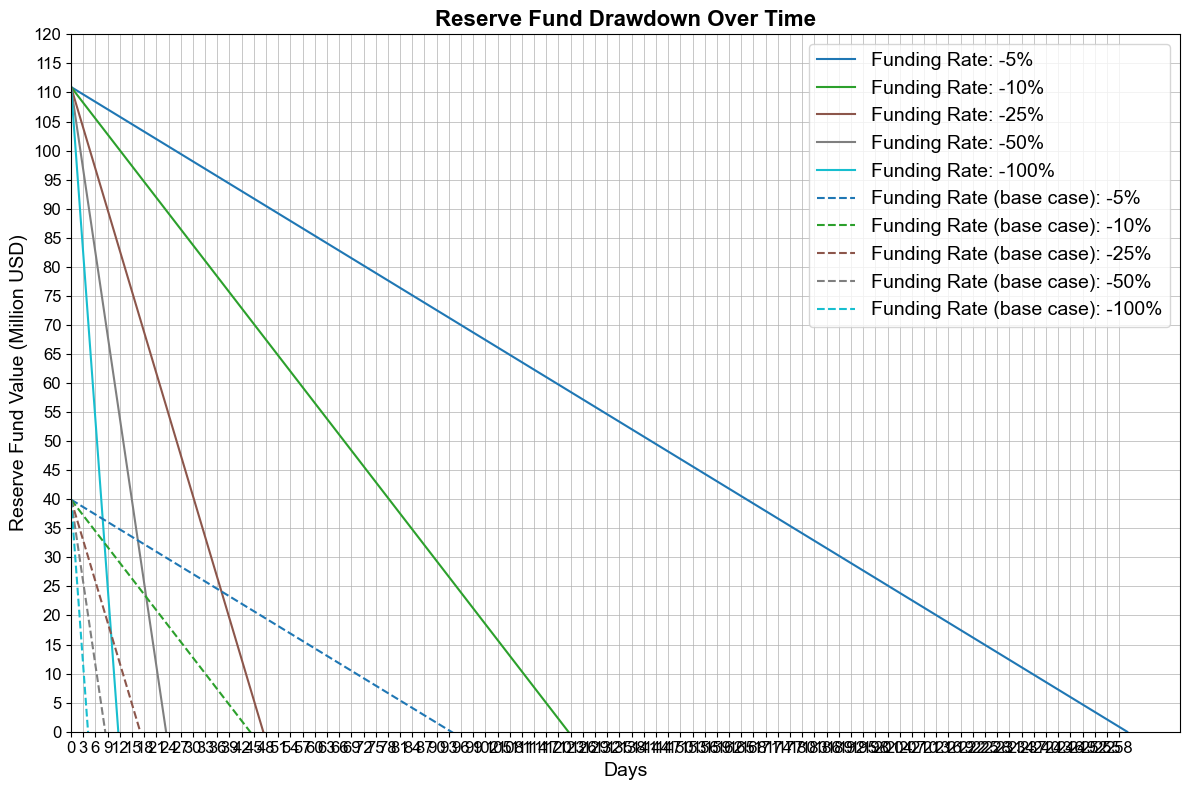

-0.05 :  261
-0.1 :  124
-0.25 :  49
-0.5 :  25
-1 :  13
39942000.0


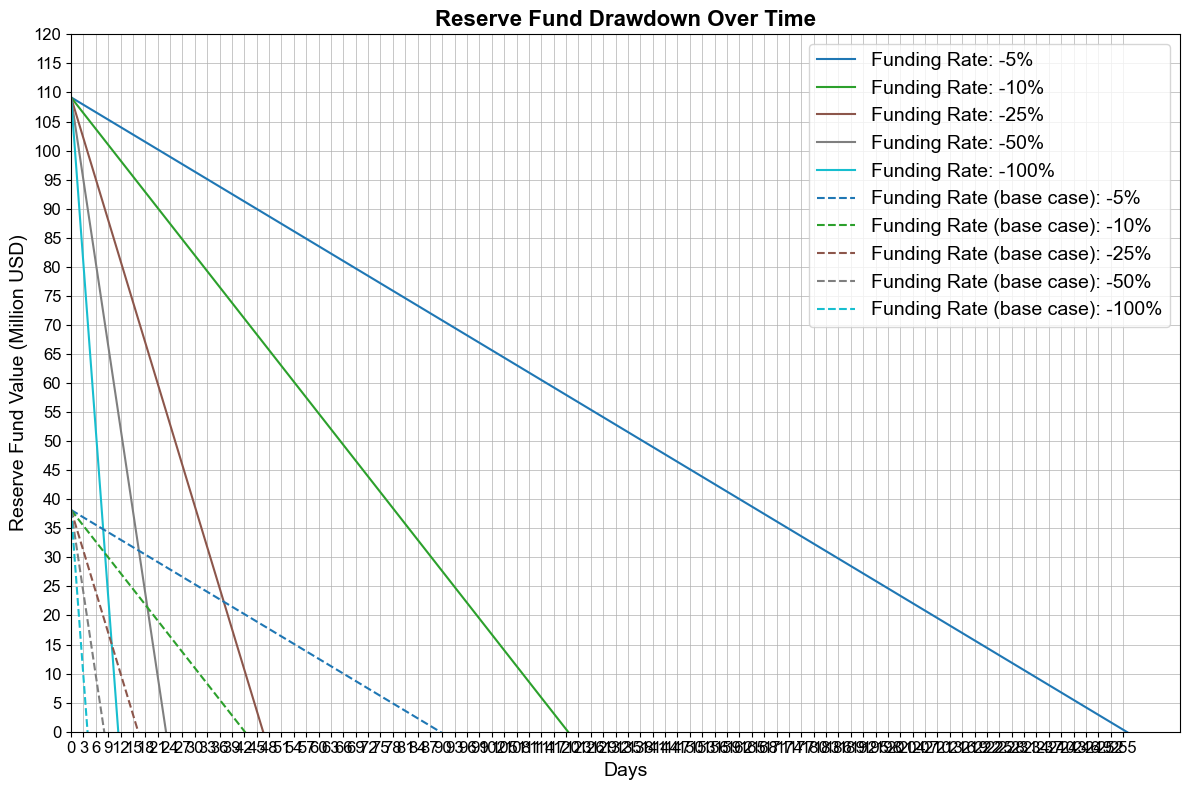

-0.05 :  257
-0.1 :  122
-0.25 :  48
-0.5 :  25
-1 :  13
38164000.0


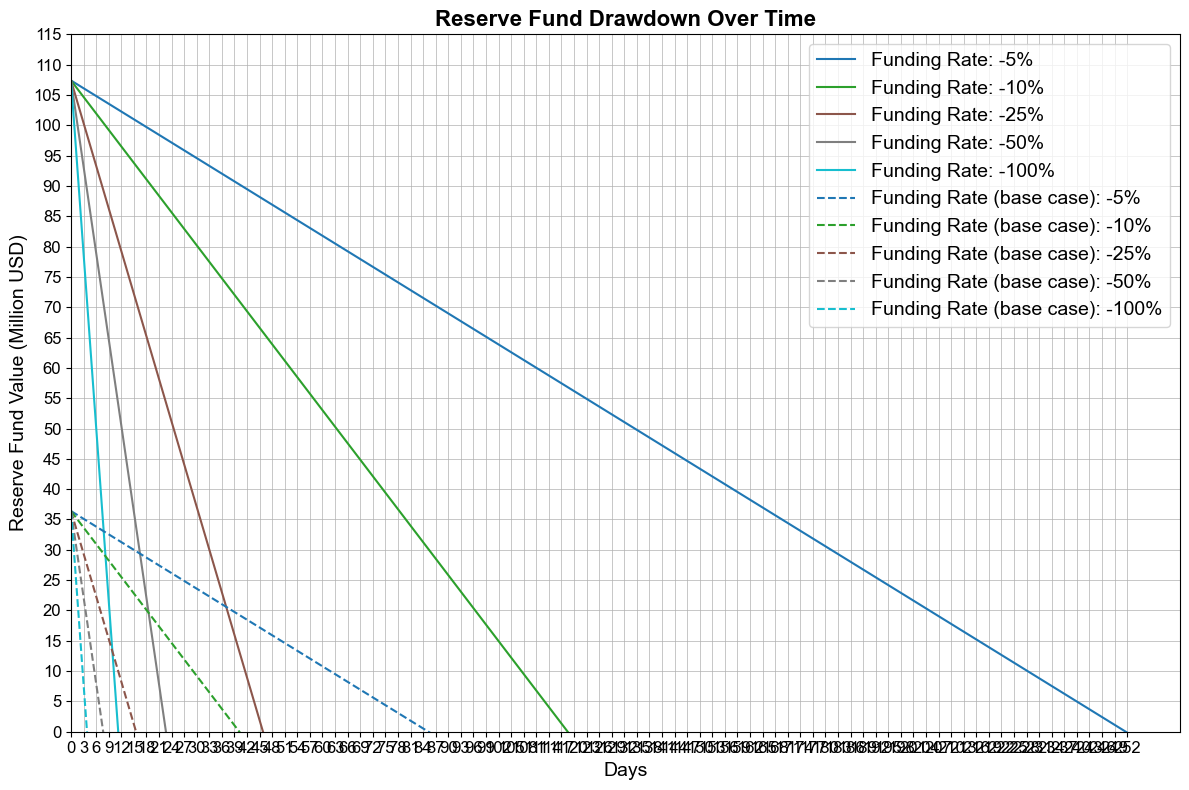

-0.05 :  253
-0.1 :  120
-0.25 :  47
-0.5 :  24
-1 :  13
36386000.0


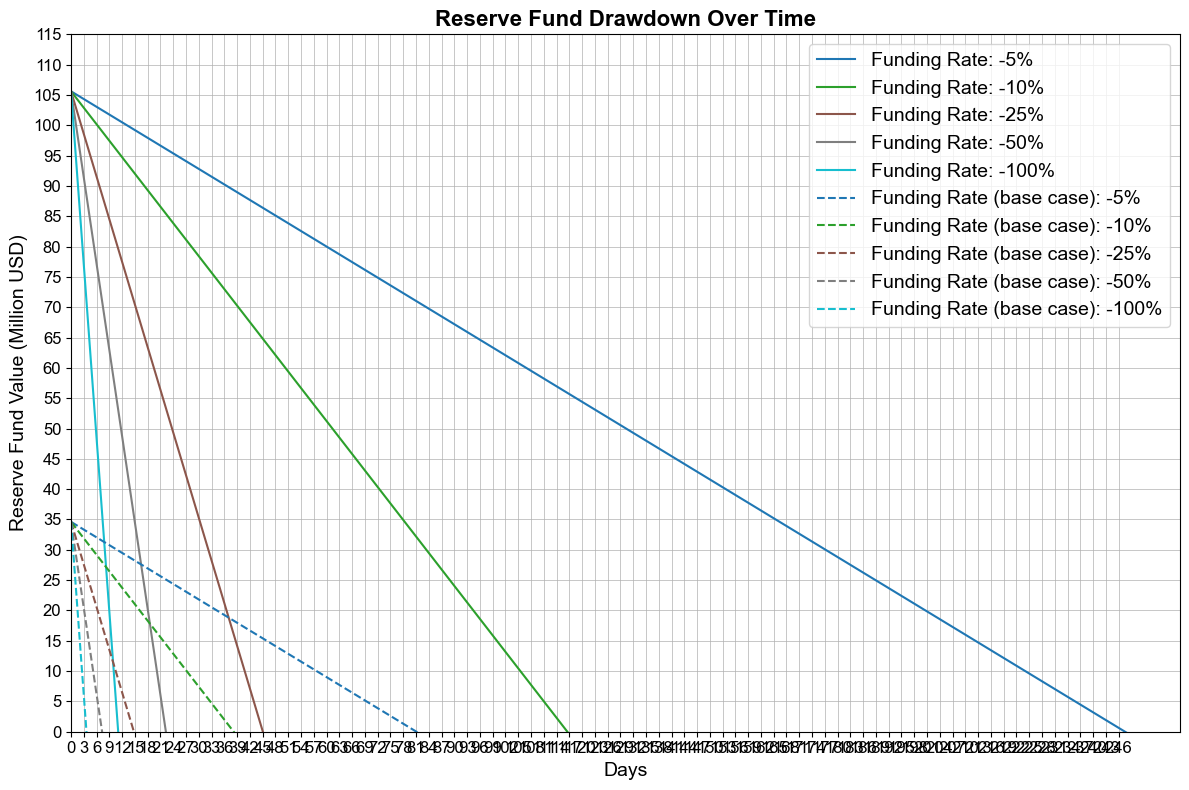

-0.05 :  249
-0.1 :  118
-0.25 :  47
-0.5 :  24
-1 :  13
34608000.0


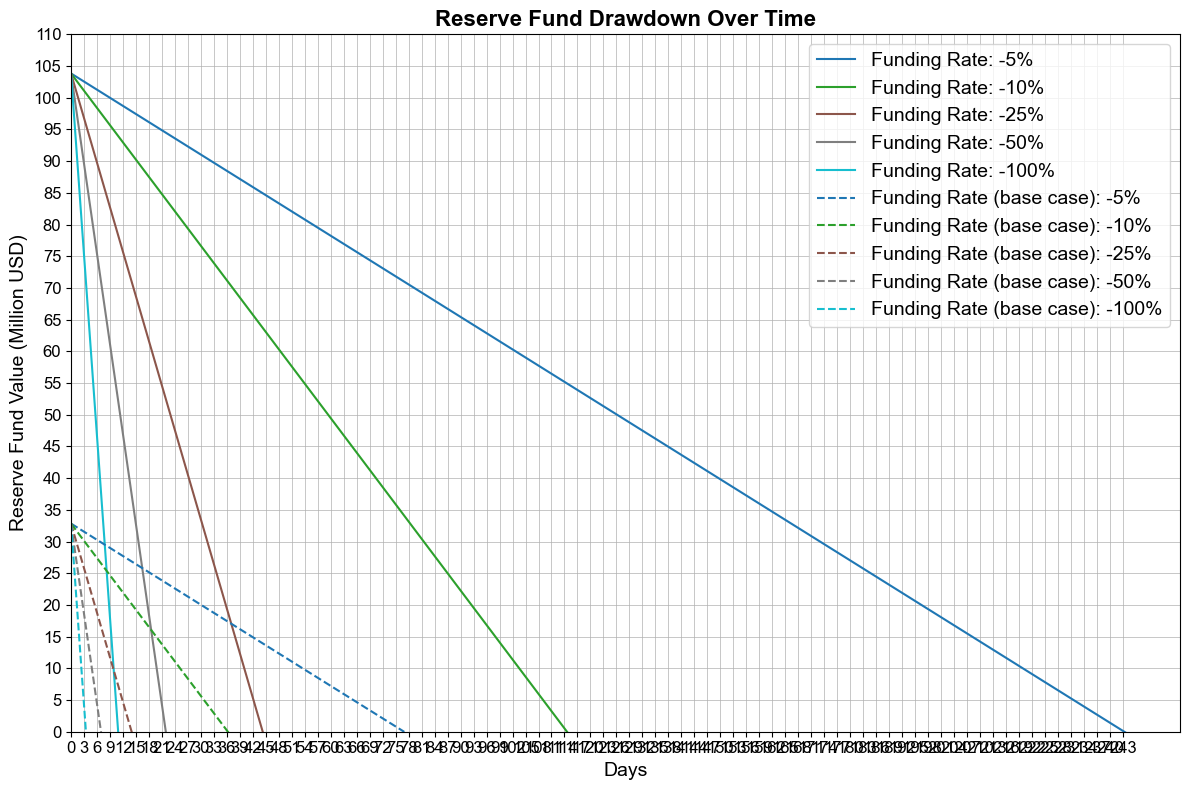

-0.05 :  245
-0.1 :  116
-0.25 :  46
-0.5 :  23
-1 :  12
32830000.0


In [12]:
reserve_fund_expected = 115000000 # $115M
reserve_fund_actual = 44000000 # $44M
# Simulations
for i, slippage in enumerate(slippage_costs):
    for discount in discount_factors:
        reserve_fund_actual_discounted = reserve_fund_actual - slippage - (uniswap_position * discount)
        reserve_fund_expected_discounted = reserve_fund_expected - slippage - (uniswap_position * discount)
        results = run_simulation(total_exposure, reserve_fund_expected_discounted, annualized_funding_rates, lst_rate, lst_proportion)
        past_results = run_simulation(total_exposure, reserve_fund_actual_discounted, annualized_funding_rates, lst_rate, lst_proportion)
        plot_results(results, past_results)
        for rate, values in results.items():
            print(rate, ": ", len(values))
        print(reserve_fund_actual_discounted)

### Observations